In [22]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

from numba import prange

In [23]:
plt.style.use("../style1.mplstyle")

In [329]:
Nr = 100
Ns = 40

In [330]:
def assertParams(muMatrix,kMatrix,dTensor,delta,supplyVec):
    assert np.shape(muMatrix) == (Ns,Nr)
    assert np.shape(kMatrix) == (Ns,Nr)
    assert np.shape(dTensor) == (Ns,Nr,Nr)
    # assert np.shape(rVec) == (Nr,)
    assert np.shape(supplyVec) == (Nr,)

    assert np.all(supplyVec >= 0)
    assert delta > 0
    assert np.all(muMatrix >= 0)
    assert np.all(kMatrix > 0)
    assert np.all(dTensor >= 0)

def binValuesFn(values,logBins=True,nBins=10,density=True):  

    if(logBins):
        positiveVals = values[values > 0]
        negativeVals = -values[values < 0]
        positiveValsBins = np.geomspace(np.min(positiveVals),np.max(positiveVals),nBins)
        negativeValsBins = np.geomspace(np.min(negativeVals),np.max(negativeVals),nBins)
        positiveHist,positiveEdges = np.histogram(positiveVals,bins=positiveValsBins,density=density)
        negativeHist,negativeEdges = np.histogram(negativeVals,bins=negativeValsBins,density=density)

        return positiveHist,positiveEdges,negativeHist,negativeEdges

    else:
        bins = np.linspace(np.min(values),np.max(values),2*nBins)
        hist,edges = np.histogram(values,bins=bins,density=density)

        return hist,edges   

@njit(parallel=True)
def chemostat_dynamics(t, y, muMatrix, kMatrix, dTensor, delta, supplyVec):
    populations = y[:Ns]
    resources = y[Ns:]

    dpop = np.zeros(Ns,dtype=np.float64)
    dres = np.zeros(Nr,dtype=np.float64)
    uptakeMatrix = (muMatrix.T * populations).T * resources / (kMatrix + resources)

    dpop = (np.sum(uptakeMatrix,axis=1) - delta*populations)    
    resourceUsage = np.sum(uptakeMatrix,axis=0)  
    
    for alpha in prange(Nr):        
        leakage = np.sum(dTensor[:,alpha,:]*uptakeMatrix)            
        dres[alpha] = delta*(supplyVec[alpha] - resources[alpha]) - resourceUsage[alpha] + leakage

    return np.concatenate((dpop,dres))

def gvecFn(muMatrix,kMatrix,rVec):
    gvec = np.zeros(Ns)
    for i in range(Ns):
        for alpha in range(Nr):
            gvec[i] += muMatrix[i,alpha]*rVec[alpha] / (kMatrix[i,alpha] + rVec[alpha])
    return gvec

def fVectorFn(supplyVec,rVec,delta):
    return delta*(supplyVec - rVec)

def eMatrixFn(muMatrix,kMatrix,dTensor,rVec):
    eMatrix = np.zeros((Nr,Ns))
    for beta in range(Nr):
        for j in range(Ns):
            leakage = 0
            for alpha in range(Nr):
                leakage += dTensor[j,beta,alpha]*muMatrix[j,alpha]*rVec[alpha] / (kMatrix[j,alpha] + rVec[alpha])
            eMatrix[beta,j] = leakage + muMatrix[j,beta] * rVec[beta] / (kMatrix[j,beta] + rVec[beta])
    return eMatrix

def sMatrixFn(muMatrix,kMatrix,rVec):
    sMatrix = np.zeros((Nr,Ns))
    for beta in range(Nr):
        for j in range(Ns):
            sMatrix[beta,j] = muMatrix[j,beta] * kMatrix[j,beta] / (kMatrix[j,beta] + rVec[beta])**2
    return sMatrix

def dedrFn(muMatrix,kMatrix,dTensor,rVec):
    dedr = np.zeros((Nr,Nr,Ns))
    for beta in range(Nr):
        for alpha in range(Nr):
            for j in range(Ns):
                dedr[beta,alpha,j] = dTensor[j,beta,alpha]*muMatrix[j,alpha]*kMatrix[j,alpha] / (kMatrix[j,alpha] + rVec[alpha])**2
            if beta == alpha:
                dedr[beta,alpha,j] += muMatrix[j,alpha] *kMatrix[j,alpha]/ (kMatrix[j,alpha] + rVec[alpha])**2
    return dedr

def mMatrixFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec):
    mMatrix = np.zeros((Nr,Nr))
    eMatrix = eMatrixFn(muMatrix,kMatrix,dTensor,rVec)
    fVec = fVectorFn(supplyVec,rVec,delta)
    dedr = dedrFn(muMatrix,kMatrix,dTensor,rVec)

    eMatrixInv = np.linalg.pinv(eMatrix)

    for alpha in range(Nr):
        for beta in range(Nr):
            doublesum = 0
            for i in range(Ns):
                for gamma in range(Nr):
                    doublesum += dedr[alpha,beta,i]*eMatrixInv[i,gamma]*fVec[gamma]
            mMatrix[alpha,beta] = doublesum - delta
    return mMatrix

def glvParamsFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec):
    fVec = fVectorFn(supplyVec,rVec,delta)
    eMatrix = eMatrixFn(muMatrix,kMatrix,dTensor,rVec)
    sMatrix = sMatrixFn(muMatrix,kMatrix,rVec)
    mMatrix = mMatrixFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec)
    mInv = np.linalg.inv(mMatrix)

    growthVec = np.dot(sMatrix.T,np.dot(mInv,fVec))
    interactionMatrix = np.dot(-sMatrix.T,np.dot(mInv,eMatrix))
    return growthVec,interactionMatrix

In [331]:
leakageRate = 0.2

unscaledMuMatrix = np.random.lognormal(-1.95,1,(Ns,Nr))
muMatrix = (1-leakageRate) * unscaledMuMatrix / np.max(unscaledMuMatrix)

kMatrix = np.random.lognormal(5.5, 1.2,(Ns,Nr))/1000

unscaledDTensor = np.random.lognormal(-8.78, 2.75,(Ns,Nr,Nr))
dTensor = 0.9* leakageRate *unscaledDTensor / np.max(unscaledDTensor)
# dTensor = np.zeros((Ns,Nr,Nr))
# dTensor = leakageRate * unscaledDTensor / np.sum(unscaledDTensor,axis=2)[:,:,np.newaxis]

supplyVec = np.full(Nr,10)
delta = 0.2

assertParams(muMatrix,kMatrix,dTensor,delta,supplyVec)

rVecBeginning = supplyVec.copy() * 0.99
rVecEnd = np.random.lognormal(np.mean(kMatrix)/np.mean(supplyVec),1,Nr)


In [332]:
growthVecBeginning,interactionMatrixBeginning = glvParamsFn(muMatrix,kMatrix,dTensor,rVecBeginning,delta,supplyVec)

In [333]:
nBins = 10

growthBeginHist,growthBeginEdges = binValuesFn(growthVecBeginning,density=False,logBins=False,nBins=nBins)
growthBeginCentres = (growthBeginEdges[:-1]+growthBeginEdges[1:])/2

intBegHistPos,intBegEdgesPos,intBegHistNeg,intBegEdgesNeg = binValuesFn(interactionMatrixBeginning.flatten(),density=False,logBins=True,nBins=5*nBins)
intBegCentresPos = (intBegEdgesPos[:-1]+intBegEdgesPos[1:])/2
intBegCentresNeg = (intBegEdgesNeg[:-1]+intBegEdgesNeg[1:])/2

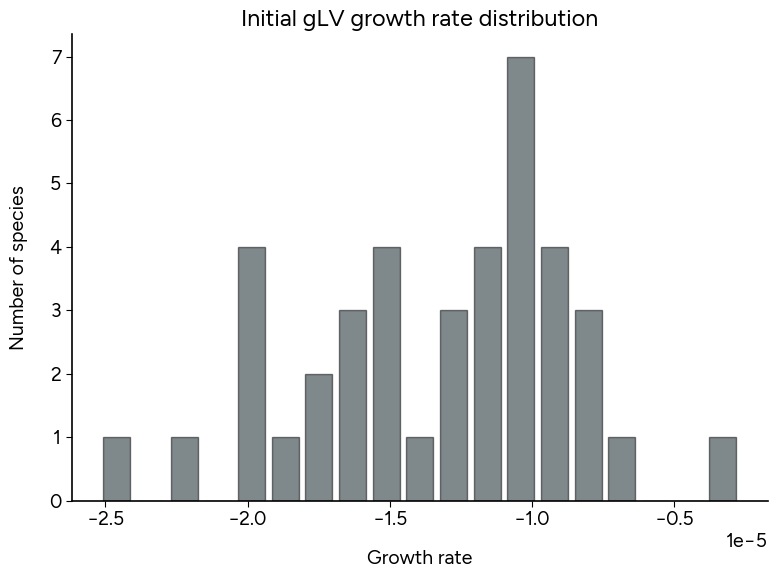

In [334]:
plt.bar(growthBeginCentres,growthBeginHist,width=np.diff(growthBeginEdges)*0.8,align="center",edgecolor="black",alpha=0.5)

plt.xlabel("Growth rate")
plt.ylabel("Number of species")
plt.title("Initial gLV growth rate distribution")

plt.show()

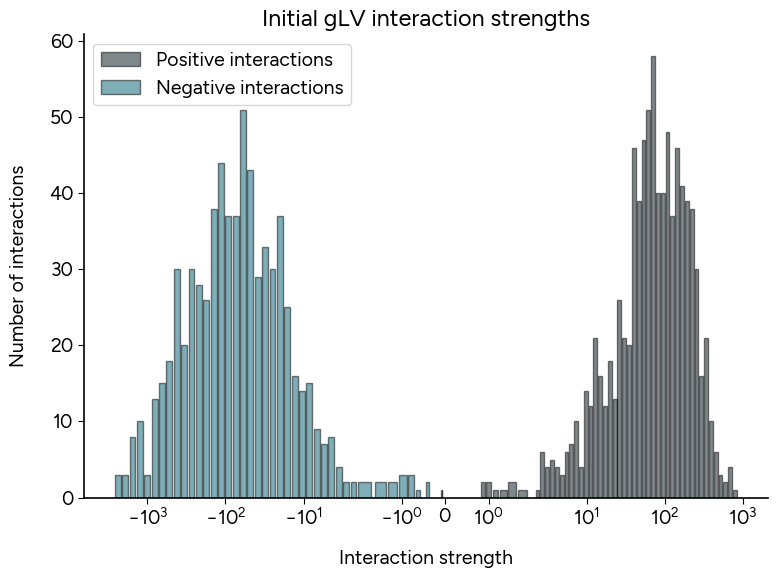

In [335]:
plt.bar(intBegCentresPos,intBegHistPos,width=np.diff(intBegEdgesPos)*0.8,align="center",edgecolor="black",alpha=0.5,label="Positive interactions")
plt.bar(-intBegCentresNeg,intBegHistNeg,width=np.diff(intBegEdgesNeg)*0.8,align="center",edgecolor="black",alpha=0.5,label="Negative interactions")


plt.xlabel("Interaction strength")
plt.ylabel("Number of interactions")
plt.title("Initial gLV interaction strengths")

plt.legend()
plt.xscale("symlog")
plt.show()

In [351]:
initialPopulations = np.full(Ns,0.05)
# initialPopulations = np.zeros(Ns)
# initialPopulations[3] = 0.05
initialResources = supplyVec

initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,200,1000)

In [352]:
%%time 
sol = integrate.solve_ivp(chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, dTensor, delta, supplyVec),t_eval=t,max_step=0.1)

CPU times: total: 2min 23s
Wall time: 3min 42s


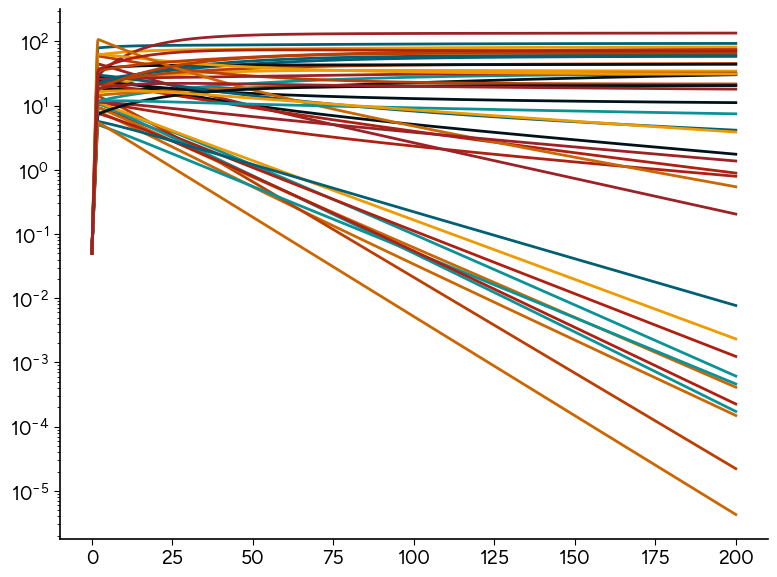

In [353]:
plt.plot(sol.t,sol.y[:Ns].T)

plt.yscale("log")
plt.show()

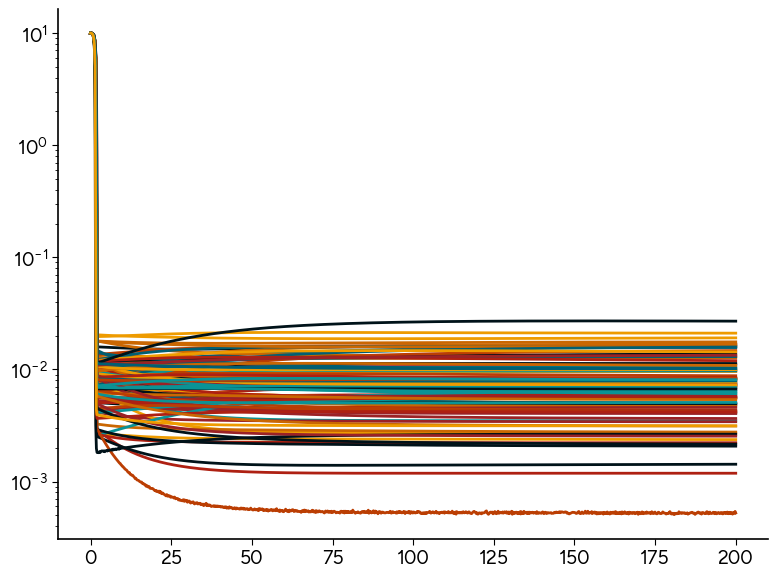

In [354]:
plt.plot(sol.t,sol.y[Ns:].T)

plt.yscale("log")
plt.show()

In [361]:
rVecEndHist,rVecEndEdges = binValuesFn(np.log(rVecEnd),density=False,logBins=False,nBins=10)
rVecEndCentres = (rVecEndEdges[:-1]+rVecEndEdges[1:])/2

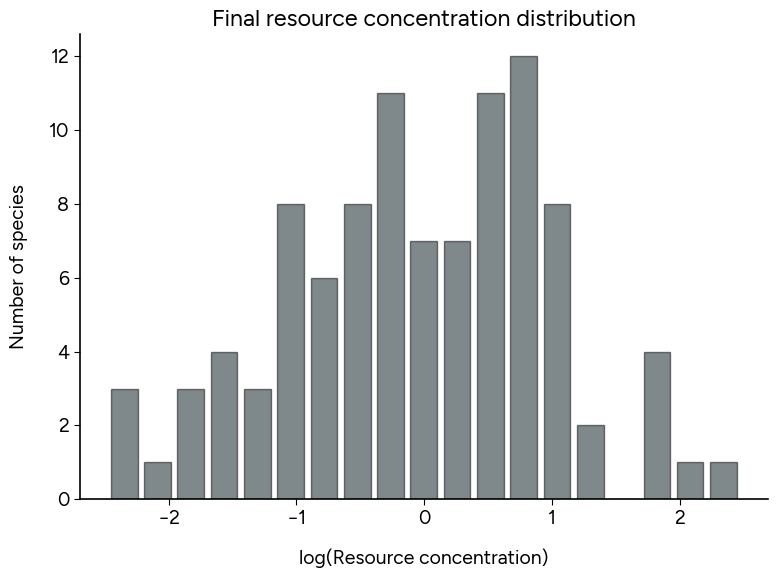

In [362]:
plt.bar(rVecEndCentres,rVecEndHist,width=np.diff(rVecEndEdges)*0.8,align="center",edgecolor="black",alpha=0.5)

plt.xlabel("log(Resource concentration)")
plt.ylabel("Number of species")

plt.title("Final resource concentration distribution")

plt.show()

In [363]:
growthVecEnd,interactionMatrixEnd = glvParamsFn(muMatrix,kMatrix,dTensor,rVecEnd,delta,supplyVec)

In [364]:
growthEndHist,growthEndEdges = binValuesFn(growthVecEnd,density=False,logBins=False,nBins=nBins)
growthEndCentres = (growthEndEdges[:-1]+growthEndEdges[1:])/2

intEndHistPos,intEndEdgesPos,intEndHistNeg,intEndEdgesNeg = binValuesFn(interactionMatrixEnd.flatten(),density=False,logBins=True,nBins=nBins*5)
intEndCentresPos = (intEndEdgesPos[:-1]+intEndEdgesPos[1:])/2
intEndCentresNeg = (intEndEdgesNeg[:-1]+intEndEdgesNeg[1:])/2

interactionEndHist,interactionEndEdges = binValuesFn(interactionMatrixEnd.flatten(),density=False,logBins=False,nBins=nBins*5)
interactionEndCentres = (interactionEndEdges[:-1]+interactionEndEdges[1:])/2

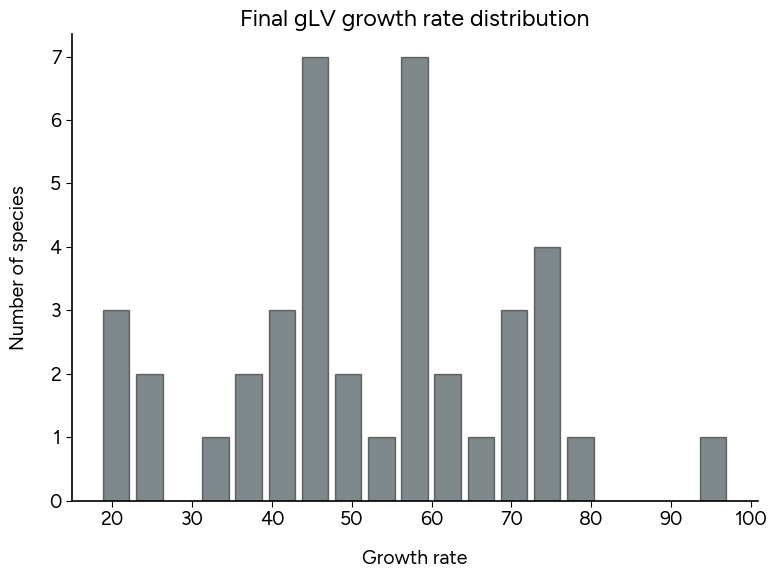

In [365]:
plt.bar(growthEndCentres,growthEndHist,width=np.diff(growthEndEdges)*0.8,align="center",edgecolor="black",alpha=0.5)

plt.xlabel("Growth rate")
plt.ylabel("Number of species")

plt.title("Final gLV growth rate distribution")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


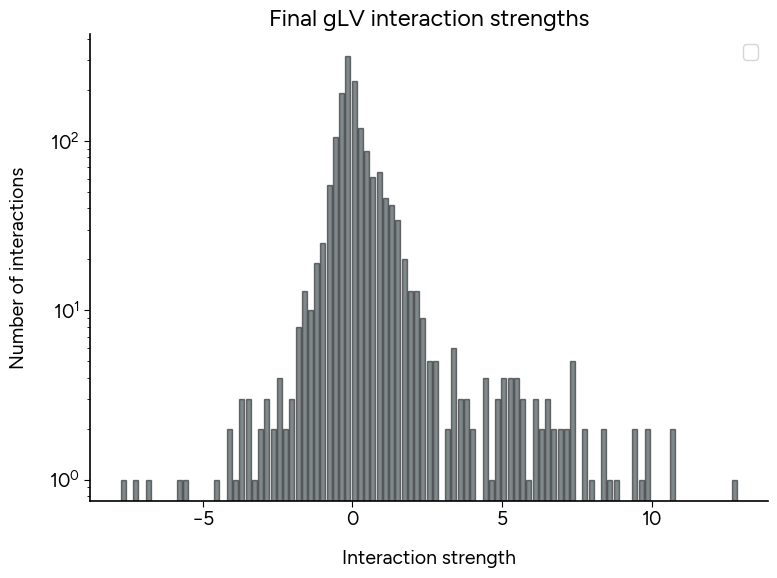

In [368]:
# plt.bar(intEndCentresPos,intEndHistPos,width=np.diff(intEndEdgesPos)*0.8,align="center",edgecolor="black",alpha=0.5,label="Positive interactions")
# plt.bar(-intEndCentresNeg,intEndHistNeg,width=np.diff(intEndEdgesNeg)*0.8,align="center",edgecolor="black",alpha=0.5,label="Negative interactions")
# plt.xscale("symlog")

plt.bar(interactionEndCentres,interactionEndHist,width=np.diff(interactionEndEdges)*0.8,align="center",edgecolor="black",alpha=0.5)
plt.yscale("log")

plt.xlabel("Interaction strength")
plt.ylabel("Number of interactions")

plt.title("Final gLV interaction strengths")

plt.legend()


plt.show()

In [190]:
growthVec,interactionMatrix = glvParamsFn(muMatrix,kMatrix,dTensor,supplyVec,delta,supplyVec*0.9)

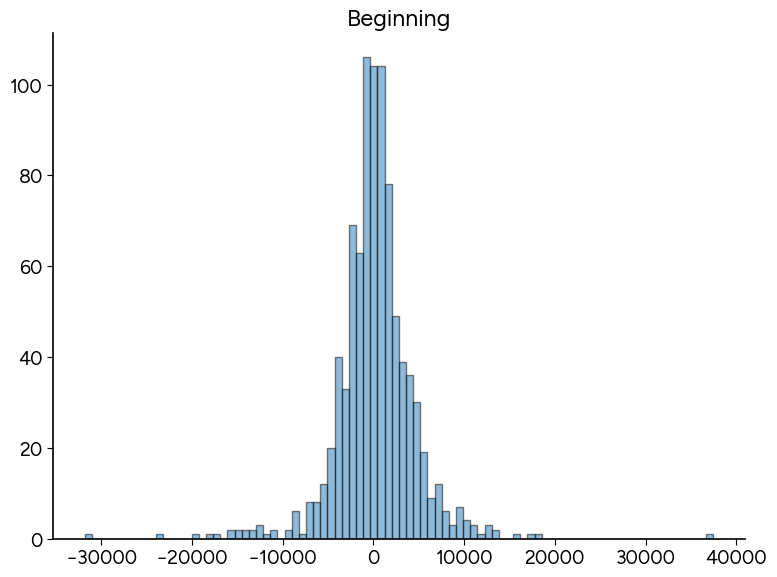

In [191]:
plt.hist(interactionMatrix.flatten(),bins="auto",color="tab:blue",alpha=0.5,edgecolor="black")

plt.title("Beginning")
plt.show()

In [171]:
dTensor =  np.zeros((Ns,Nr,Nr))
growthVec,interactionMatrix = glvParamsFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec)

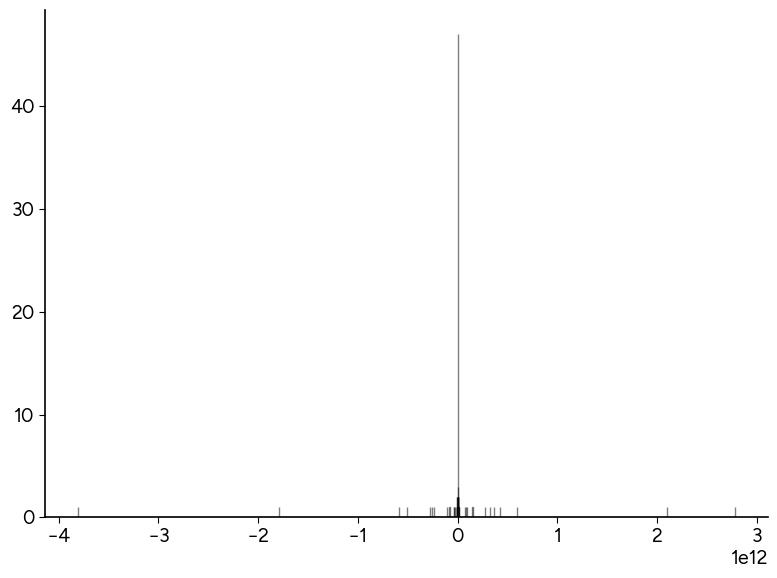

In [172]:
plt.hist(interactionMatrix.flatten(),bins="auto",color="tab:blue",alpha=0.5,edgecolor="black")

plt.show()

In [148]:
initialPopulations = np.random.uniform(0,1,Ns)
initialResources = np.random.uniform(0,1,Nr)

initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,100,1000)

In [149]:
sol = integrate.solve_ivp(chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, dTensor, delta, supplyVec),t_eval=t)

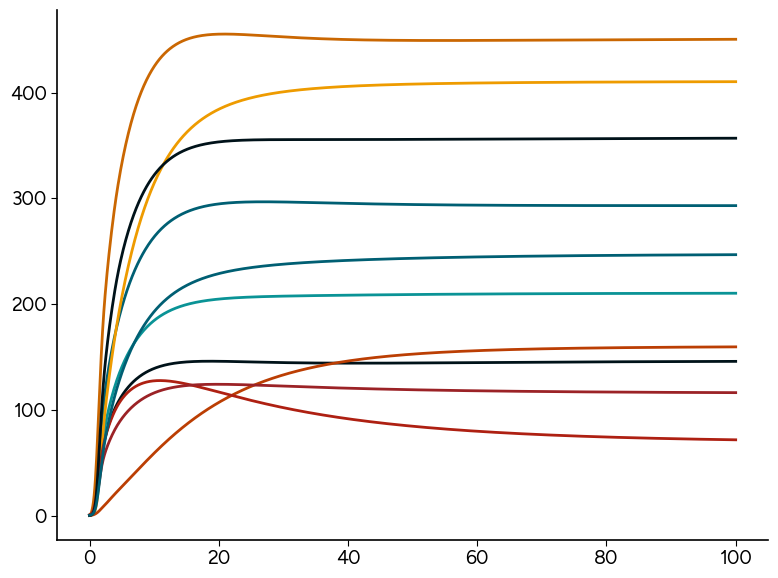

In [150]:
plt.plot(sol.t,sol.y[:Ns].T)

plt.show()

In [156]:
minresconc = np.min(sol.y[Ns:,-1])
maxresconc = np.max(sol.y[Ns:,-1])
bins = np.geomspace(minresconc,maxresconc,20)

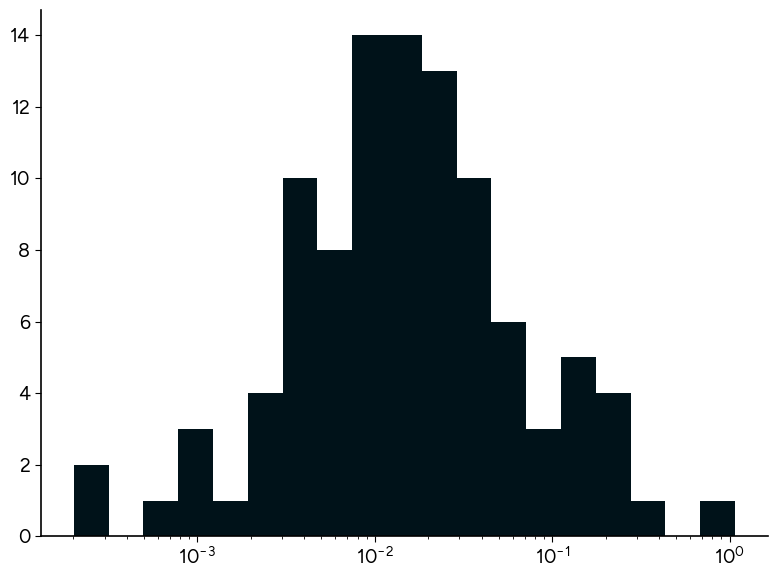

In [158]:
plt.hist(sol.y[Ns:,-1],bins=bins)

plt.xscale("log")
plt.show()